# **Foundations of Deep Learning Project:** *Rice Image Dataset*

Mario Pedol (830296), 
Veronica Morelli (839257).

To develop the project we use the dataset available on Kaggle at the following link: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset. The dataset is called *Rice Image Dataset*. It contains 75K images including 15K images for each rice variety that are: Arborio, Basmati, Ipsala, Jasmine and Karacadag.

We decide to use the dataset to solve a **classification problem**. We want to find a performing deep learning model to correctly classify 5 types of rice.

We mainly use two approaches:

*  **Convolutional Neaural Network from scratch**
*  **Transfer learning and Fine Tuning and feature extraction**

In the first case we design a new architecture of a Convolutional Neural Network from scratch. 

In the second case we use completely a Pre-trained Neural Network adding a Feed-Forward Neural Network to improve the performances.  

Neural networks with the best performances are presented in this notebook.

***Notebook 1*** and ***Notebook 2*** contain all the attempts.

To finally choose the best model, we created a new dataset, called *test* on which we fitted the two models. The model with better classificatory goodness-of-fit is chosen as the best model. 



## 1) **Environment Set Up**

This section is made to configure the environment, import useful libraries and set up the directories:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.models import Sequential,  Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50, MobileNet,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_inputMN
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_inputVG


In [ ]:
# Import main libraries

from time import time
from datetime import datetime
from google.colab import drive

import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
print('TensorFlow version:', tf.__version__)

import zipfile
from shutil import copyfile


import numpy as np
import pandas as pd
import random as python_random

import glob
import shutil
from random import seed
from random import random
import os
import os.path


from IPython.display import Javascript


TensorFlow version: 2.8.2


In [ ]:
# Mount GDrive
drive.mount('/content/gdrive/', force_remount = True) 

<IPython.core.display.Javascript object>

Mounted at /content/gdrive/


## 2) **Image Loading and Sampling**

In our case, the data preparation phase for further analysis consists of two steps: **loading data onto the drive** and **sampling**.

1. Unzipping and loading the original dataset with 75K images in total, particularly 15K per class

2. Sampling the data in order to train the model faster

The computational time with which this operation is performed is 5 hours and 46 minutes.

In [ ]:
# t0 = time()

# # copyfile('rice.zip', 'rice.zip')

# zip = zipfile.ZipFile('rice.zip')
# zip.extractall()
# zip.close()

# print("File transfer completed in %0.3f seconds" % (time() - t0))

<IPython.core.display.Javascript object>

We now define a new function called *random_sampling()* that randomly samples the original dataset by extracting *n* images per class, where *n* is defined by us. 

In this case we extract 2K images per class, for a total of 10K images. Recall that the target classes are equidistributed.

A *seed* is set for reproducibility.

In [ ]:
def random_sampling(index, src_dir=None, dst_dir=None):
  
  for riso in os.listdir(src_dir):

    dir = src_dir + str(riso) # Source dir for every rice type
    dst = dst_dir + str(riso) # Destination dir for every rice type

    if(os.path.exists(dst)):
      os.remove(dst)

    if not os.path.isdir(dst): #create folder for every rice type in not exist
      os.makedirs(dst)

    for i, jpgfile in enumerate(glob.iglob(os.path.join(dir, "*.jpg"))):
      if i in index:  
        shutil.copy(jpgfile, dst)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Draw sample from the original dataset 
from random import randint

# Index for Random Sampling
index = []
for _ in range(2000):
	value = randint(0, 15000)
	index.append(value)

# Define source dir and destination dir
src_dir = '/content/gdrive/MyDrive/FDL2022Project/Dati/Original/Rice_Image_Dataset/'
dst_dir = '/content/gdrive/MyDrive/FDL2022Project/Dati/Sample/Final/'

import random
random.seed(123)
random_sampling(index, src_dir=src_dir, dst_dir=dst_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3) **EDA:** Exploratory Data Analysis

Before entering the heart of the modeling phase, an exploratory analysis is performed to understand what the dataset looks like.

In [ ]:
base_path = '/content/gdrive/MyDrive/FDL2022Project/Dati/Sample/Final/'

<IPython.core.display.Javascript object>

As previously mentioned the dataset consists of a set of images of rice grains classified into 5 types:

- Arborio
- Basamti
- Ipsala
- Jasmine
- Karacadag.

In [ ]:
rice_classes=os.listdir(base_path)
print(rice_classes)

<IPython.core.display.Javascript object>

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


We print the 3 dimensions of the image *Arborio (10).jpg*: width, height and depth. We use the information of *Arborio (10).jpg* assuming that each image of the dataset has the same dimensions.

The images have dimensions 250x250x3 where 250 is the width, 250 is the height e 3 is the depth. Each image has 3 color channels, which means it is RGB type.



In [ ]:
image = cv2.imread(base_path + 'Arborio/Arborio (10).jpg')

print(type(image))

print('-------')

print('Width:', image.shape[0])
print('Height:', image.shape[1])
print('Channels:', image.shape[2])



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To see if the images were correctly imported and to explore the dataset, we decide to print the first image for each type of rice grain. 

<IPython.core.display.Javascript object>

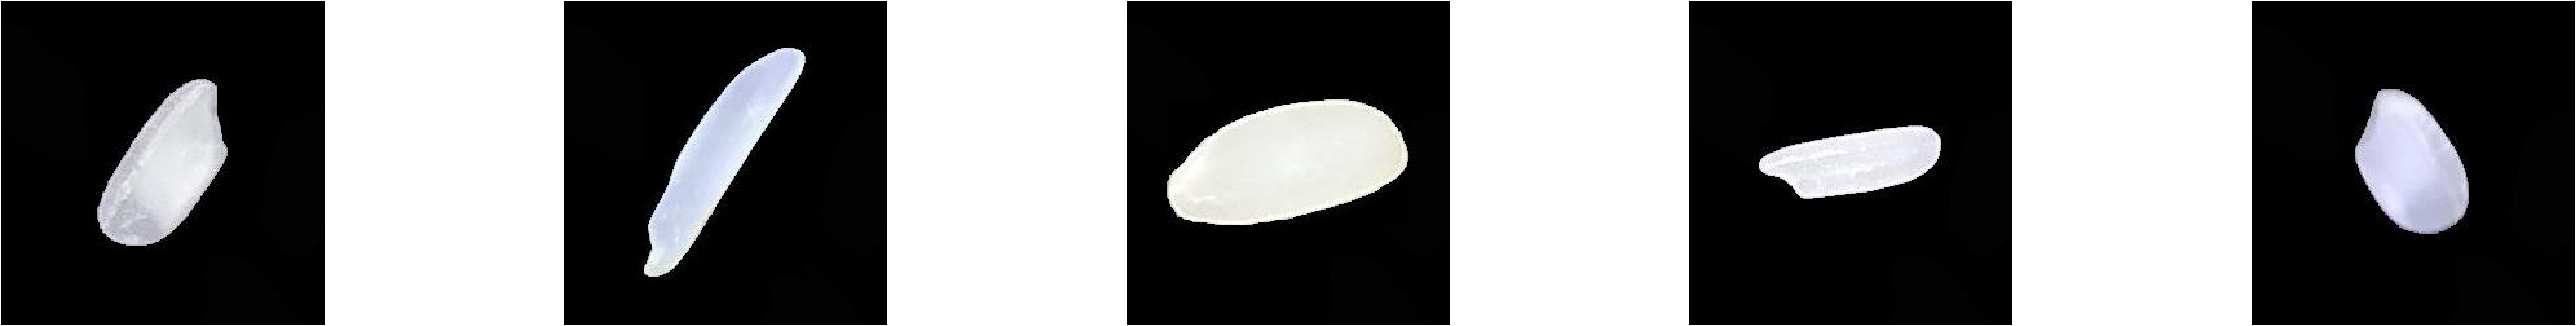

In [ ]:
plt.figure(0, figsize=(250,250))
cpt = 0

for riso in os.listdir(base_path):
    for i in range(1,2):
        cpt = cpt + 1
        sp=plt.subplot(7,5,cpt)
        sp.axis('Off')
        img_path = base_path + riso + "/" +os.listdir(base_path + riso+ "/")[i]
        img = load_img( img_path, target_size=(250,250))
        plt.imshow(img, cmap="gray")


plt.show()

From these outputs we notice how the rice grains in these 5 images differ from each other in characteristics such as length, width or shape.

In this example, the first image (type *Arborio*) is similar to the fifth (type *Karacadag*)

In the exploratory analysis, it is important to know the **distribution of the classes of the target variable** in the dataset that will be trained. It is possible that some classes are under-represented or over-represented, consequently the variable's classes may be unbalanced. New techniques should be used to deal with this problem.

In [ ]:
df_distribution_train = pd.DataFrame()
for riso in os.listdir(base_path):
    dir = base_path + str(riso) 
    ln = len(os.listdir(dir))
    new = pd.DataFrame({'Expression':[riso], 'n_images':ln})
    df_distribution_train = pd.concat([df_distribution_train,new])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

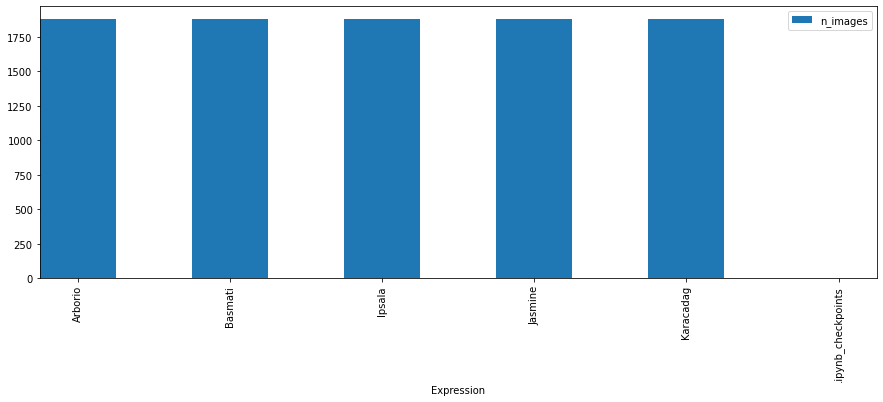

In [ ]:
ax = df_distribution_train.plot.bar(x='Expression',y='n_images',figsize=(15, 5))
ax.autoscale(axis='x',tight=True);

From this graph we can see how the target's classes are equidistributed. In fact, there are 2000 images for each type of rice grain. No further action will be taken in consideration.

##4)  **Preprocessing** and **Splitting into Training and Validation**

### 4.1) **Preprocessing** and **Splitting into Training and Validation** for **Best Model from scratch**

Before proceeding to the actual analysis phase, it is necessary to split the whole dataset into two datasets: **training set** and **validation set**. 80% of the data is contained in the training while 20% of the data is contained in the validation.

On the training dataset, the data are standardized (*rescale=1.0/255.0*). In addition, to make the classificatory model as generalizable as possible on new data, the technique of **data augmentation** is used. Data augmentation creates a more complete and consistent set of data. We applied different techniques of data augmentation, in particular data warping techniques such as: *width shift*, *height shift*, *horizontal flip*, *vertical flip* an *rotation*. All this approaches trasform the datas preserving the original labels.

On the validation dataset, the data are only standardized (*rescale=1.0/255.0*).

Finally, two **data loaders** are defined.

The batch size is set to 32. The images are risized from 250x250 to 224x224 dimension.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

<IPython.core.display.Javascript object>

In [ ]:
# Training dataset: standardization + data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 20,
                                   validation_split=0.2)

<IPython.core.display.Javascript object>

In [ ]:
# Validation dataset: standardization

validation_datagen = ImageDataGenerator(rescale=1/255,
                                        validation_split=0.2)

<IPython.core.display.Javascript object>

In [ ]:
# Training data loader

train_generator = train_datagen.flow_from_directory(base_path,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=1)                                                                    


<IPython.core.display.Javascript object>

Found 7505 images belonging to 5 classes.


In [ ]:
# Validation data loader

validation_generator = validation_datagen.flow_from_directory(base_path,
                                                              target_size=(224,224),
                                                              color_mode='rgb',
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              subset='validation',
                                                              shuffle=False,
                                                              seed=1) 

<IPython.core.display.Javascript object>

Found 1875 images belonging to 5 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

<IPython.core.display.Javascript object>

(32, 224, 224, 3)
(32, 5)


###4.2) **Preprocessing** and **Splitting into Training and Validation** for **Best Model with Transfer Learning**

As done in the previous section, a training dataset and a validation dataset are defined, with their respective data loaders. 
Compared with the previous case, in addition to standardization and data augmentation, **preprocessing of the ResNet50** network is added.

In [ ]:
size=224
channels=3
batch_size = 64
num_classes = 5

# Training set

train_processing = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                      validation_split=0.2,
                                      rotation_range = 25,
                                      width_shift_range = .2,
                                      height_shift_range = .2,
                                      horizontal_flip = True,
                                      zoom_range = .2)

In [ ]:

# Validation set

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                        validation_split=0.2)



In [ ]:
# Training data loader 

train_generator_tf = train_processing.flow_from_directory (base_path,   
                                                     target_size=(size, size), 
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     subset='training',
                                                     color_mode="rgb",
                                                     interpolation='nearest')


In [ ]:
# Validation data loader

validation_generator_tf = validation_datagen.flow_from_directory(base_path,  
                                                              target_size=(size,size),
                                                              subset='validation',
                                                              color_mode="rgb",
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              shuffle=False,
                                                              interpolation='nearest')

In [ ]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

<IPython.core.display.Javascript object>

(64, 224, 224, 3)
(64, 5)


## 5) ***Best Model***

###5.1) **Best Model from scratch**

The best model is the **Model_v7** where the neural network is named as **net7** (see Notebook 1). 

This neural network is chosen as the best mainly for two reasons. <br/>
First, it has an accuracy on validation of 99%: the *val_accuracy* at the 40th epoch is 0.99. This means that the neural network correctly classifies 99% of images it receives as input after 40 epochs. <br/>
Second, the accuracy remains constant from the 25th epoch onward to the 40th epoch, which suggests that the model is stable. 

In this case the model is trained for 30 epochs.

The model's architecture is presented in the cell below.

**Architecture Model from scratch**

* Input Layer
* 2d Convolutional layer (3x3 filter, 32 hidden neurons, Ridge regularizer, He uniform inizializer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d convolutional Layer (3x3, 64 hidden neurons, Ridge regularizer, He uniform inizializer)
* Relu activation
* Batch Normalization layer
* Max Pooling layer (3x3)
* 2d Convolutional layer (3x3 filter, 128 hidden neurons, Ridge regularizer, He uniform inizializer)
* Relu activation
* Batch Normalization layer
* Global Max Pooling layer
* Dense layer (Softmax Activation, ridge regularizer)

In [ ]:
num_classes = 5

<IPython.core.display.Javascript object>

In [ ]:
# Architecture definition

inputs = keras.Input((224, 224, 3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = 'same')(x)

x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_regularizer = tf.keras.regularizers.l2(), kernel_initializer= tf.keras.initializers.HeUniform(seed=123) )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer=tf.keras.regularizers.l2())(x)
net1 = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

A summary and plot of the neural network architecture described above is shown in the cells below. 
In particular, we note that the total number of parameters to be estimated is 94 789 of which 94 341 are trainable while 448 are not.

In [ ]:
# Architecture summary

net1.summary()

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496 

<IPython.core.display.Javascript object>

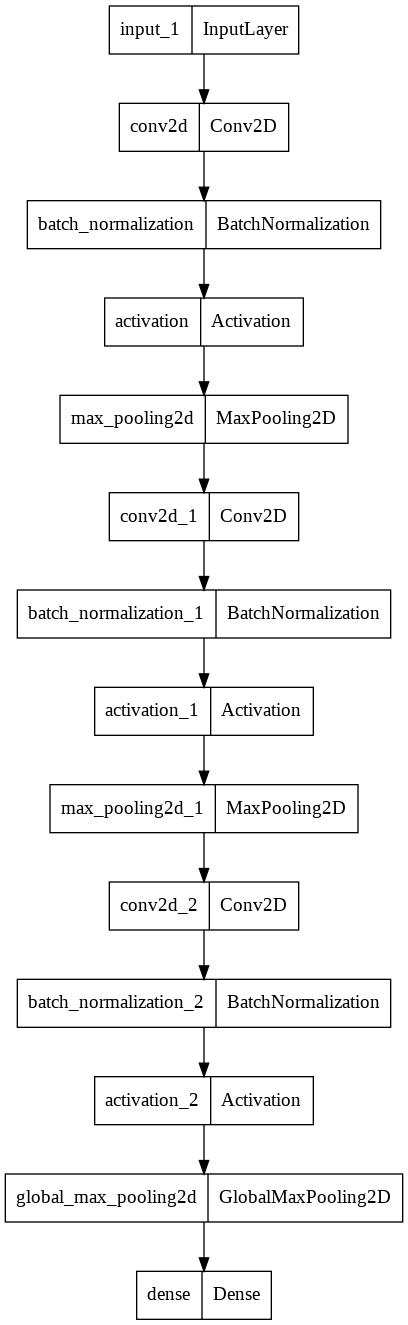

In [ ]:
# Architecture plot

keras.utils.plot_model(net1)

In the next step, the network is trained for the classification task. Specifically, **categorical crossentropy** is chosen as the loss function, **RMSprop** is chosen as the optimizer, and **accuracy** is chosen as the metric for evaluating classification goodness-of-fit. 

In [ ]:
# Network Compilation

net1.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
             metrics =['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# Reduce Learning Rate

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
                                                 mode='min',
                                                 patience=3, 
                                                 verbose=1, 
                                                 factor=0.5, 
                                                 min_lr=0.000001)

<IPython.core.display.Javascript object>

In [ ]:
# Training

history1 = net1.fit(train_generator,
                    epochs = 30,
                    validation_data = validation_generator,
                    callbacks = [reduce_lr]);

<IPython.core.display.Javascript object>

Epoch 1/30
235/235 [==============================] - 2043s 9s/step - loss: 3.8973 - accuracy: 0.7472 - val_loss: 3.5086 - val_accuracy: 0.2293 - lr: 0.0010
Epoch 2/30
235/235 [==============================] - 617s 3s/step - loss: 1.7010 - accuracy: 0.9037 - val_loss: 3.4450 - val_accuracy: 0.2299 - lr: 0.0010
Epoch 3/30
235/235 [==============================] - 619s 3s/step - loss: 1.0733 - accuracy: 0.9332 - val_loss: 2.2324 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 4/30
235/235 [==============================] - 625s 3s/step - loss: 0.7973 - accuracy: 0.9402 - val_loss: 1.6053 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 5/30
235/235 [==============================] - 625s 3s/step - loss: 0.6522 - accuracy: 0.9446 - val_loss: 0.9814 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 6/30
235/235 [==============================] - 620s 3s/step - loss: 0.5706 - accuracy: 0.9459 - val_loss: 1.3622 - val_accuracy: 0.6987 - lr: 0.0010
Epoch 7/30
235/235 [==============================] - 621s 3s/s

<IPython.core.display.Javascript object>

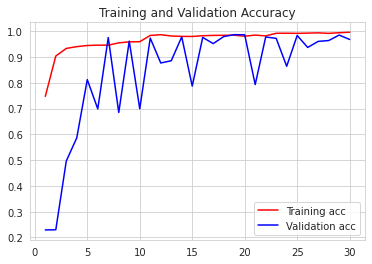

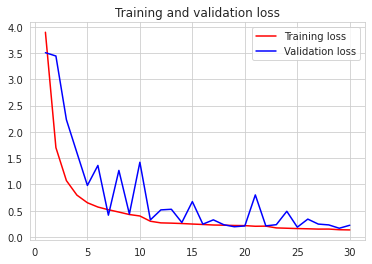

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and Validation Accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
Y_pred = net1.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
report1 = classification_report(validation_generator.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

<IPython.core.display.Javascript object>

,precision,recall,f1-score,support
Arborio,1.000000,0.853333,0.920863,375.000
Basmati,0.989446,1.000000,0.994695,375.000
Ipsala,0.968992,1.000000,0.984252,375.000
Jasmine,0.894231,0.992000,0.940582,375.000
Karacadag,1.000000,0.994667,0.997326,375.000
accuracy,0.968000,0.968000,0.968000,0.968
macro avg,0.970534,0.968000,0.967544,1875.000
weighted avg,0.970534,0.968000,0.967544,1875.000


It can be seen from the classification report that the model has very good classification goodness-of-fit for all classes of the target variable. <br/>
In particular, the model **doesn't overfit** in the last epochs, aproximately from the 23th epoch. The overall **accuracy** on the validation set is high and equal to 0.968. <br/>
Finally, we can note that the model is stable in the last 10/15 epochs. <br/>
It can be said that rice grain images are often correctly classified.


In the cell below we save the model.

In [ ]:
# Saving

net1.save('/content/gdrive/MyDrive/FDL2022Project/modelli ve/BestModelFromScratch.h5')

<IPython.core.display.Javascript object>

###5.2) **Best Model with Transfer Learning**

To achieve better performance than those obtained on the networks previously developed we use **Transfer learning** (fine tuning) approach. The best pre-trained netework selected from **Notebook 2** is the ResNet50.

In [ ]:
pretrained_model = resnet50.ResNet50(
    weights='imagenet', 
    include_top=False,  
    input_shape=(size, size, 3), 
    pooling='avg',  
)

<IPython.core.display.Javascript object>

94781440/94765736 [==============================] - 0s 0us/step


We want to freeze the weights that we ''inherited'' from the pretraining on imagenet:

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in pretrained_model.layers])

for layer in pretrained_model.layers:
    layer.trainable = False

<IPython.core.display.Javascript object>

Now we can definie the network architecture as follow:
- Dense layer 2048 neurons, activation function "relu".
- Dense layer 512 neurons, activation function "relu".
- Dropout layer 0.15.
- Dense layer 128 neurons, activation function "relu".
- Dense layer 64 neurons, activation function "relu".
- Dropout layer 0.15.
- Dense layer 32 neurons, activation function "relu".
- Dense layer 16 neurons, activation function "relu".
- Output layer 5 output neurons, activation function "softmax".

In [ ]:
x2 = pretrained_model.output
x2 = Dense(2048,'relu')(x2)
x2 = Dense(512,'relu')(x2)
x2 = Dropout(.15)(x2)
x2 = Dense(128,'relu')(x2)
x2 = Dense(64,'relu')(x2)
x2 = Dropout(.15)(x2)
x2 = Dense(32,'relu')(x2)
x2 = Dense(16,'relu')(x2)
pred2 = Dense(5,'softmax')(x2)

model2 =  Model(inputs=pretrained_model.input, outputs=pred2)

<IPython.core.display.Javascript object>

A summary of the neural network architecture described above is shown in the cells below. 
In particular, we note that the total number of parameters to be estimated is 28 909 765 of which 5 322 053 are trainable while 23 587 712 are not. In particular, the parameter not trainable are the ones from the ResNet50. 

In [ ]:
model2.summary()

<IPython.core.display.Javascript object>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model2.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

<IPython.core.display.Javascript object>

In [ ]:
history = model2.fit_generator(
    generator=train_generator_tf,
    epochs=25,  
    validation_data=validation_generator_tf,
    callbacks=[EarlyStopping])

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/25
118/118 [==============================] - 1994s 17s/step - loss: 0.5351 - accuracy: 0.8139 - val_loss: 0.2574 - val_accuracy: 0.9024
Epoch 2/25
118/118 [==============================] - 108s 913ms/step - loss: 0.1743 - accuracy: 0.9435 - val_loss: 0.0841 - val_accuracy: 0.9701
Epoch 3/25
118/118 [==============================] - 107s 907ms/step - loss: 0.1288 - accuracy: 0.9578 - val_loss: 0.1028 - val_accuracy: 0.9611
Epoch 4/25
118/118 [==============================] - 108s 913ms/step - loss: 0.1044 - accuracy: 0.9647 - val_loss: 0.0887 - val_accuracy: 0.9643
Epoch 5/25
118/118 [==============================] - 107s 907ms/step - loss: 0.0886 - accuracy: 0.9708 - val_loss: 0.0510 - val_accuracy: 0.9787
Epoch 6/25
118/118 [==============================] - 107s 908ms/step - loss: 0.0739 - accuracy: 0.9769 - val_loss: 0.0663 - val_accuracy: 0.9765
Epoch 7/25
118/118 [==============================] - 109s 920ms/step - loss: 0.0736 - accuracy: 0.9755 - val_loss: 0.0490 - 

<IPython.core.display.Javascript object>

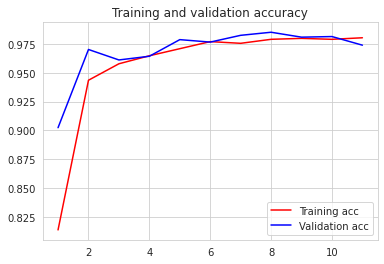

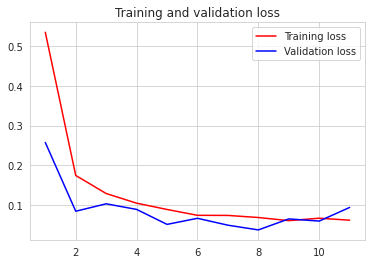

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

sns.set_style("whitegrid")
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [ ]:
model2.save('/content/gdrive/MyDrive/FDL2022Project/modelli ve/BestTransfer.h5')

<IPython.core.display.Javascript object>

In [ ]:
Y_pred = model2.predict(validation_generator_tf)
y_pred = np.argmax(Y_pred, axis=1)
report1 = classification_report(validation_generator_tf.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

<IPython.core.display.Javascript object>

,precision,recall,f1-score,support
Arborio,0.971204,0.989333,0.980185,375.000000
Basmati,0.981627,0.997333,0.989418,375.000000
Ipsala,0.992021,0.994667,0.993342,375.000000
Jasmine,0.991690,0.954667,0.972826,375.000000
Karacadag,0.989333,0.989333,0.989333,375.000000
accuracy,0.985067,0.985067,0.985067,0.985067
macro avg,0.985175,0.985067,0.985021,1875.000000
weighted avg,0.985175,0.985067,0.985021,1875.000000


The result is very satisfactory, the **validation accuracy** achieved is 98%, and the network never overfit: **validation loss** is always under the Training curve, the same is for the accuracy. 

## 6. **Test**

To finally choose the best model, we created a new dataset, called **test** on which we fitted the two models. 

The test dataset contains 100 images per class, consequently it contains 500 images. 

In [ ]:
# Draw sample from the original dataset 
from random import randint

# Index for Random Sampling
index = []
for _ in range(100):
	value = randint(0, 15000)
	index.append(value)

#Define source dir and destination dir
src_dir = '/content/gdrive/MyDrive/FDL2022Project/Dati/Original/Rice_Image_Dataset/'
dst_dir = '/content/gdrive/MyDrive/FDL2022Project/Dati/Sample/Test/'

import random
random.seed(123)
random_sampling(index, src_dir=src_dir, dst_dir=dst_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_path = '/content/gdrive/MyDrive/FDL2022Project/Dati/Sample/Test/'

<IPython.core.display.Javascript object>

### 6.1) **Preprocessing** and **Splitting into Training and Validation** for **Best Model from scratch**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

<IPython.core.display.Javascript object>

In [ ]:
# Validation dataset: standardization

test_datagen1 = ImageDataGenerator(rescale=1/255,
                                  validation_split=0.2)

<IPython.core.display.Javascript object>

In [ ]:
# Training data loader

test_generator1 = test_datagen1.flow_from_directory(test_path,
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    seed=1)                                                                    


<IPython.core.display.Javascript object>

Found 500 images belonging to 5 classes.


In [ ]:
# net_test_BfS = keras.models.load_model('/content/gdrive/MyDrive/FDL2022Project/modelli ve/BestModelFromScratch.h5')

In [ ]:
rice_classes = os.listdir(test_path)
print(rice_classes)

<IPython.core.display.Javascript object>

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [ ]:
Y_pred_testBfS = net1.predict(test_generator1)
y_pred_testBfS = np.argmax(Y_pred_testBfS, axis=1)
report_testBfS  = classification_report(test_generator1.classes, y_pred_testBfS, target_names=rice_classes, output_dict=True)
df1_testBfS = pd.DataFrame(report_testBfS).transpose()
df1_testBfS

<IPython.core.display.Javascript object>

,precision,recall,f1-score,support
Arborio,1.000000,0.860,0.924731,100.000
Basmati,0.980392,1.000,0.990099,100.000
Ipsala,0.943396,1.000,0.970874,100.000
Jasmine,0.915888,0.980,0.946860,100.000
Karacadag,1.000000,0.990,0.994975,100.000
accuracy,0.966000,0.966,0.966000,0.966
macro avg,0.967935,0.966,0.965508,500.000
weighted avg,0.967935,0.966,0.965508,500.000


### 6.2) **Preprocessing** and **Splitting into Training and Validation** for **Best Model with Transfer Learning**

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50)

<IPython.core.display.Javascript object>

In [ ]:
size=224
channels=3
batch_size = 64
num_classes = 5

<IPython.core.display.Javascript object>

In [ ]:
test_generator_tf = test_datagen.flow_from_directory(test_path,  
                                                     target_size=(size,size),
                                                     color_mode="rgb",
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=False,
                                                     interpolation='nearest')

<IPython.core.display.Javascript object>

Found 500 images belonging to 5 classes.


In [ ]:
from tensorflow import keras
model2 = keras.models.load_model('/content/gdrive/MyDrive/FDL2022Project/modelli ve/BestTransfer.h5')

<IPython.core.display.Javascript object>

In [ ]:
Y_pred = model2.predict(test_generator_tf)
y_pred = np.argmax(Y_pred, axis=1)
report2 = classification_report(test_generator_tf.classes, y_pred, target_names=rice_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

<IPython.core.display.Javascript object>

,precision,recall,f1-score,support
Arborio,0.970874,1.000,0.985222,100.000
Basmati,0.961538,1.000,0.980392,100.000
Ipsala,1.000000,1.000,1.000000,100.000
Jasmine,1.000000,0.950,0.974359,100.000
Karacadag,1.000000,0.980,0.989899,100.000
accuracy,0.986000,0.986,0.986000,0.986
macro avg,0.986482,0.986,0.985974,500.000
weighted avg,0.986482,0.986,0.985974,500.000
